Json bien structuré

In [2]:
import re
import json
from typing import List, Dict, Optional

class RedditParser:
    def __init__(self, text: str):
        self.text = text
        self.posts = []

    def extract_comments(self, comment_section: str) -> List[Dict]:
        """
        Extract comments from a comment section.
        Returns a list of comment dictionaries with level, author, and content.
        """
        comments = []
        comment_pattern = r'\(level (\d+)\) Comment by (\w+): (.*?)(?=(?:\n  - \(level|\Z))'
        
        for match in re.finditer(comment_pattern, comment_section, re.DOTALL):
            level = int(match.group(1))
            author = match.group(2)
            content = self.clean_text(match.group(3))
            
            comment = {
                'level': level,
                'author': author,
                'content': content,
                'replies': []  # Will be populated for nested comments
            }
            comments.append(comment)

        # Organize comments into a tree structure
        comment_tree = []
        comment_stack = []
        
        for comment in comments:
            while comment_stack and comment['level'] <= comment_stack[-1]['level']:
                comment_stack.pop()
                
            if comment_stack:
                comment_stack[-1]['replies'].append(comment)
            else:
                comment_tree.append(comment)
                
            comment_stack.append(comment)

        return comment_tree

    def extract_posts(self) -> List[Dict]:
        """
        Extract posts and their comments from the text.
        Returns a list of dictionaries containing post information and comments.
        """
        # Split the text into sections based on "=== Post"
        post_sections = re.split(r'=== Post #\d+ ===', self.text)
        
        # Remove any empty sections
        post_sections = [section.strip() for section in post_sections if section.strip()]

        for section in post_sections:
            post_data = {}
            
            # Extract title
            title_match = re.search(r'Title: (.*?)(?:\nBody:|$)', section, re.DOTALL)
            if title_match:
                post_data['title'] = title_match.group(1).strip()

            # Extract body
            body_match = re.search(r'Body: (.*?)(?:---|\Z)', section, re.DOTALL)
            if body_match:
                post_data['body'] = body_match.group(1).strip()
            else:
                post_data['body'] = ""

            # Extract subreddit
            subreddit_match = re.search(r'(?:from|in) r/(\w+)', section)
            if subreddit_match:
                post_data['subreddit'] = subreddit_match.group(1)
            else:
                # If no subreddit found in the section, try to find it in the larger context
                subreddit_match = re.search(r'(?:from|in) r/(\w+)', self.text)
                if subreddit_match:
                    post_data['subreddit'] = subreddit_match.group(1)
                else:
                    post_data['subreddit'] = "unknown"

            # Extract comments
            comments_section_match = re.search(r'--- Comments \(Up to level \d+\) ---\n(.*?)(?=(?:\n===|\Z))', section, re.DOTALL)
            if comments_section_match:
                comments_text = comments_section_match.group(1)
                post_data['comments'] = self.extract_comments(comments_text)
            else:
                post_data['comments'] = []

            if post_data.get('title'):  # Only add if we at least have a title
                self.posts.append(post_data)

        return self.posts

    def clean_text(self, text: str) -> str:
        """Clean the text by removing extra whitespace and special characters."""
        if not text:
            return ""
        # Remove extra whitespace
        text = ' '.join(text.split())
        # Remove any special Reddit formatting
        text = re.sub(r'\[\w+\]|\(http[s]?://[^\)]+\)', '', text)
        return text.strip()

    def process_and_save(self, output_file: str) -> None:
        """
        Process the text and save the results to a JSON file.
        """
        # Extract and clean the posts
        posts = self.extract_posts()
        
        # Clean the text in each post
        for post in posts:
            post['title'] = self.clean_text(post['title'])
            post['body'] = self.clean_text(post['body'])

        # Save to JSON file
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump({'posts': posts}, f, indent=2, ensure_ascii=False)

def main():
    # Read the input file
    with open('output.txt', 'r', encoding='utf-8') as f:
        text = f.read()

    # Create parser instance
    parser = RedditParser(text)
    
    # Process and save to JSON
    parser.process_and_save('reddit_posts.json')

if __name__ == "__main__":
    main()

In [3]:
import json
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

def get_sentiment_label(compound_score):
    """Convert compound score to sentiment label."""
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def analyze_text(text, analyzer):
    """Analyze sentiment of a text using VADER."""
    scores = analyzer.polarity_scores(text)
    sentiment = get_sentiment_label(scores['compound'])
    return {
        'sentiment': sentiment,
        'scores': {
            'negative': scores['neg'],
            'neutral': scores['neu'],
            'positive': scores['pos'],
            'compound': scores['compound']
        }
    }

def analyze_comments(comments, analyzer):
    """Analyze comments recursively."""
    analyzed_comments = []
    
    for comment in comments:
        # Analyze current comment
        sentiment_result = analyze_text(comment['content'], analyzer)
        
        analyzed_comment = {
            'author': comment['author'],
            'content': comment['content'],
            'level': comment['level'],
            'sentiment': sentiment_result['sentiment'],
            'sentiment_scores': sentiment_result['scores']
        }
        
        # Analyze replies recursively
        if comment.get('replies'):
            analyzed_comment['replies'] = analyze_comments(comment['replies'], analyzer)
        else:
            analyzed_comment['replies'] = []
            
        analyzed_comments.append(analyzed_comment)
    
    return analyzed_comments

def main():
    print("Initializing VADER sentiment analyzer...")
    analyzer = SentimentIntensityAnalyzer()
    
    # Load Reddit data
    print("Loading Reddit data...")
    try:
        with open('reddit_posts.json', 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading Reddit data: {str(e)}")
        return
    
    analyzed_posts = []
    
    # Process each post
    print("Analyzing posts and comments...")
    try:
        for post in tqdm(data['posts'], desc="Processing posts"):
            # Analyze post content
            post_text = f"{post['title']} {post['body']}"
            post_sentiment = analyze_text(post_text, analyzer)
            
            analyzed_post = {
                'subreddit': post['subreddit'],
                'title': post['title'],
                'body': post['body'],
                'sentiment': post_sentiment['sentiment'],
                'sentiment_scores': post_sentiment['scores']
            }
            
            # Analyze comments if present
            if post.get('comments'):
                analyzed_post['comments'] = analyze_comments(post['comments'], analyzer)
            else:
                analyzed_post['comments'] = []
                
            analyzed_posts.append(analyzed_post)
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return
    
    # Save results
    try:
        print("Saving results...")
        # Save detailed analysis
        with open('sentiment_analysis.json', 'w', encoding='utf-8') as f:
            json.dump({'posts': analyzed_posts}, f, indent=2, ensure_ascii=False)
        
        # Create summary DataFrame
        summary_data = []
        for post in analyzed_posts:
            comment_sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}
            
            def count_sentiments(comments):
                for comment in comments:
                    comment_sentiments[comment['sentiment']] += 1
                    if comment['replies']:
                        count_sentiments(comment['replies'])
            
            count_sentiments(post['comments'])
            
            summary_data.append({
                'subreddit': post['subreddit'],
                'title': post['title'],
                'post_sentiment': post['sentiment'],
                'sentiment_compound': post['sentiment_scores']['compound'],
                'comment_count': sum(comment_sentiments.values()),
                'positive_comments': comment_sentiments['positive'],
                'neutral_comments': comment_sentiments['neutral'],
                'negative_comments': comment_sentiments['negative']
            })
        
        # Save summary
        df = pd.DataFrame(summary_data)
        df.to_csv('sentiment_summary.csv', index=False)
        
        print("\nAnalysis complete!")
        print("Results saved to:")
        print("- sentiment_analysis.json (detailed analysis)")
        print("- sentiment_summary.csv (summary statistics)")
        
        # Display summary statistics
        print("\nSummary of analyzed posts:")
        print(df)
        
    except Exception as e:
        print(f"Error saving results: {str(e)}")

if __name__ == "__main__":
    main()

Initializing VADER sentiment analyzer...
Loading Reddit data...
Analyzing posts and comments...


Processing posts: 100%|██████████| 5/5 [00:00<00:00, 1630.38it/s]

Saving results...

Analysis complete!
Results saved to:
- sentiment_analysis.json (detailed analysis)
- sentiment_summary.csv (summary statistics)

Summary of analyzed posts:
    subreddit                                              title  \
0  NVDA_Stock  NVIDIA GeForce RTX 5080 reportedly launches Ja...   
1      stocks  NVIDIA GeForce RTX 5080 reportedly launches Ja...   
2  NVDA_Stock                                  Portfolio in 2025   
3  NVDA_Stock  The AI Revolution: Top 10 Tech Stocks Poised f...   
4  NVDA_Stock                                $53 of NVDA in 2001   

  post_sentiment  sentiment_compound  comment_count  positive_comments  \
0       positive              0.2960              0                  0   
1        neutral              0.0000              2                  2   
2       negative             -0.1531              0                  0   
3       positive              0.8074              0                  0   
4       positive              0.9002          

Visualizations have been created in the 'figures' directory!
The following files were generated:
- sentiment_distribution.png
- compound_scores.png
- subreddit_sentiment.png
- comments_analysis.png
- analysis_summary.json


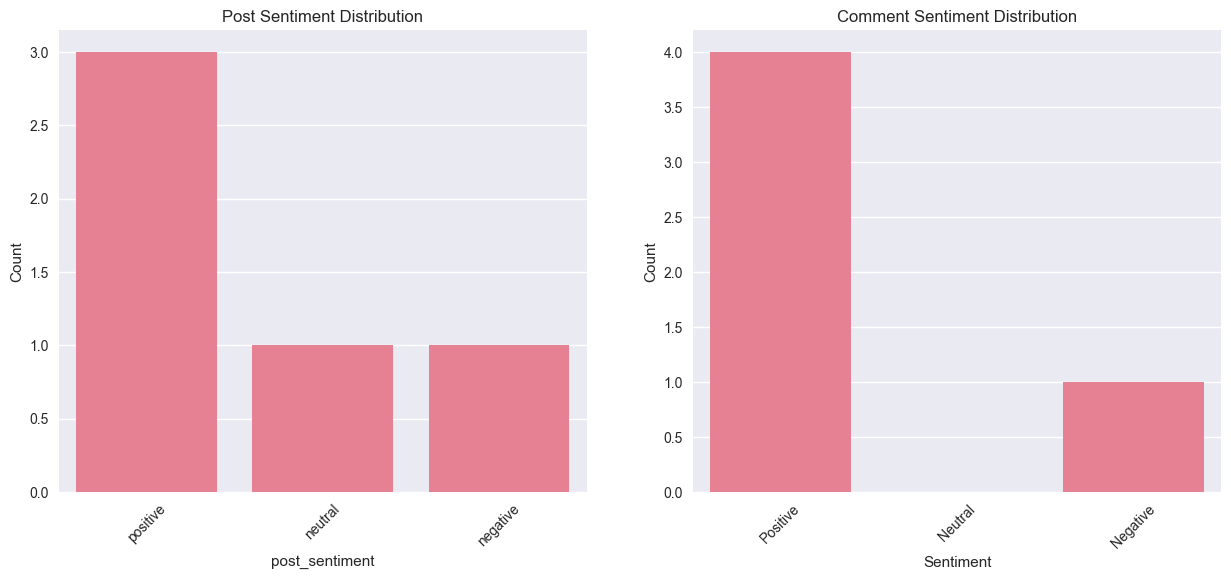

<Figure size 1200x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    """Custom encoder for numpy data types"""
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class SentimentVisualizer:
    def __init__(self, csv_path):
        """Initialize with path to sentiment analysis CSV file."""
        self.df = pd.read_csv(csv_path)
        
        # Set style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")
        
    def create_sentiment_distribution(self, save_path='figures'):
        """Create sentiment distribution plots."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Posts sentiment distribution
        posts_sentiment_counts = self.df['post_sentiment'].value_counts()
        sns.barplot(x=posts_sentiment_counts.index, y=posts_sentiment_counts.values, ax=ax1)
        ax1.set_title('Post Sentiment Distribution')
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45)
        
        # Comments distribution (positive/neutral/negative)
        comment_counts = pd.DataFrame({
            'Sentiment': ['Positive', 'Neutral', 'Negative'],
            'Count': [
                self.df['positive_comments'].sum(),
                self.df['neutral_comments'].sum(),
                self.df['negative_comments'].sum()
            ]
        })
        sns.barplot(data=comment_counts, x='Sentiment', y='Count', ax=ax2)
        ax2.set_title('Comment Sentiment Distribution')
        ax2.set_ylabel('Count')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.figure(figsize=(15, 6))  # Create new figure with larger size
        plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin
        plt.savefig(f'{save_path}/sentiment_distribution.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    def create_compound_score_plot(self, save_path='figures'):
        """Create compound score visualization."""
        plt.figure(figsize=(15, 8))  # Increased figure size
        
        # Create bar plot of compound scores
        bars = plt.bar(range(len(self.df)), self.df['sentiment_compound'])
        
        # Color bars based on sentiment
        colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
        for bar, sentiment in zip(bars, self.df['post_sentiment']):
            bar.set_color(colors[sentiment])
        
        plt.title('Sentiment Compound Scores by Post', pad=20)
        plt.xlabel('Posts')
        plt.ylabel('Compound Score')
        
        # Rotate and align the tick labels so they look better
        plt.xticks(range(len(self.df)), 
                  self.df['title'].str[:30] + '...', 
                  rotation=45,
                  ha='right')
        
        # Add horizontal line at y=0
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
        
        # Adjust layout
        plt.subplots_adjust(bottom=0.2)
        
        plt.savefig(f'{save_path}/compound_scores.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    def create_subreddit_analysis(self, save_path='figures'):
        """Create subreddit-level sentiment analysis."""
        if self.df['subreddit'].nunique() > 1:
            plt.figure(figsize=(12, 8))
            
            subreddit_sentiment = pd.crosstab(self.df['subreddit'], self.df['post_sentiment'])
            subreddit_sentiment.plot(kind='bar', stacked=True)
            
            plt.title('Sentiment Distribution by Subreddit')
            plt.xlabel('Subreddit')
            plt.ylabel('Count')
            plt.legend(title='Sentiment')
            plt.xticks(rotation=45, ha='right')
            
            plt.subplots_adjust(bottom=0.2)
            plt.savefig(f'{save_path}/subreddit_sentiment.png', bbox_inches='tight', dpi=300)
            plt.close()
    
    def create_comment_analysis(self, save_path='figures'):
        """Create visualization of comments analysis."""
        plt.figure(figsize=(15, 8))
        
        # Prepare data
        comments_data = self.df[['title', 'positive_comments', 'neutral_comments', 'negative_comments']]
        comments_data = comments_data.set_index('title')
        
        # Create stacked bar chart
        ax = comments_data.plot(kind='bar', stacked=True)
        
        plt.title('Comment Sentiment Distribution by Post')
        plt.xlabel('Posts')
        plt.ylabel('Number of Comments')
        plt.legend(title='Comment Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Rotate and align the tick labels so they look better
        plt.xticks(rotation=45, ha='right')
        
        # Adjust layout to prevent label cutoff
        plt.subplots_adjust(bottom=0.2, right=0.85)
        plt.savefig(f'{save_path}/comments_analysis.png', bbox_inches='tight', dpi=300)
        plt.close()
        
    def create_all_visualizations(self, save_path='figures'):
        """Create all visualizations."""
        # Create output directory if it doesn't exist
        Path(save_path).mkdir(exist_ok=True)
        
        self.create_sentiment_distribution(save_path)
        self.create_compound_score_plot(save_path)
        self.create_subreddit_analysis(save_path)
        self.create_comment_analysis(save_path)
        
        # Create summary statistics with native Python types
        summary = {
            'total_posts': int(len(self.df)),
            'sentiment_distribution': {
                k: int(v) for k, v in self.df['post_sentiment'].value_counts().to_dict().items()
            },
            'comment_statistics': {
                'total_comments': int(self.df['comment_count'].sum()),
                'positive_comments': int(self.df['positive_comments'].sum()),
                'neutral_comments': int(self.df['neutral_comments'].sum()),
                'negative_comments': int(self.df['negative_comments'].sum())
            },
            'subreddits': self.df['subreddit'].unique().tolist(),
            'average_compound_score': float(self.df['sentiment_compound'].mean())
        }
        
        # Save summary to JSON using custom encoder
        with open(f'{save_path}/analysis_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2, cls=NumpyEncoder)

def main():
    try:
        # Initialize visualizer
        visualizer = SentimentVisualizer('sentiment_summary.csv')
        
        # Create all visualizations
        visualizer.create_all_visualizations()
        
        print("Visualizations have been created in the 'figures' directory!")
        print("The following files were generated:")
        print("- sentiment_distribution.png")
        print("- compound_scores.png")
        print("- subreddit_sentiment.png")
        print("- comments_analysis.png")
        print("- analysis_summary.json")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()